# GAN - MNIST
Implementación de una GAN en Pytorch con el set de MNIST

### Importación de librerias

In [4]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

In [5]:
from utils import Logger

### Carga de los datos

In [6]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         # Normalizamos los datos en el rango -1 a 1
         transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    out_dir = '../../PytorchDatasets/MNIST'
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

In [7]:
# Carga de los datos
data = mnist_data()

# Creacion del data loader que usa Pytorch, para iterar sobre el
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)

# Num batches
num_batches = len(data_loader)

### Funciones de utilidad

In [8]:
def images_to_vectors(images):
    """
    Con esta funcion pasamos las imagenes a vectores -> Flatten
    """
    return images.view(images.size(0), 784).type(torch.cuda.FloatTensor)

In [9]:
def vectors_to_images(vectors):
    """
    Con esta funcion pasamos los vectores a imagenes
    """
    return vectors.view(vectors.size(0), 1, 28, 28).type(torch.cuda.FloatTensor)

In [12]:
def noise(samples):
    """
    Con esta funcion creamos tantas muestras como 'samples'
    formadas por ruido gausiano con una distribucion normal
    con media 0 y varianza 1. Dimensionalidad 100 (la misma que
    toma el generador para samplear muestras)
    """
    return Variable(torch.randn(samples, 100)).type(torch.cuda.FloatTensor)

In [28]:
def real_data_target(samples):
    """
    Funcion para crear un vector utilizado para asignar la clase de las 
    diferentes muestras durante el entrenamiento de tamaño 'samples'
    Recordar que con 1s indicamos que la muestra es 'real'
    """
    return Variable(torch.ones(samples, 1)).type(torch.cuda.FloatTensor)

In [29]:
def fake_data_target(samples):
    """
    Funcion para crear un vector utilizado para asignar la clase de las 
    diferentes muestras durante el entrenamiento de tamaño 'samples'
    Recordar que con 0s indicamos que la muestra es 'falsa'
    """
    return Variable(torch.zeros(samples, 1)).type(torch.cuda.FloatTensor)

### Redes!

#### Discriminador

In [10]:
class DiscriminatorNet(nn.Module):
    """
    Red neuronal de tres capas ocultas que funcionara como discriminador:
      - Toma como entrada una imagen 'aplanada' (28x28 -> 784), y devolvemos
        la probabilidad de que la imagen provenga del dataset real. 
        (1 -> real) (0 -> sintetico)
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784 # Imagen de entrada en vector
        n_out = 1 # Numero neuronas de salida. Solo necesitamos una
        
        # Primera capa oculta, entran n_features y tenemos 1024 neuronas
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        # Segunda capa oculta, entran 1024 neuronas de la capa anterior y salen 512
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        # Tercera capa oculta, entran 512 neuronas de la capa anterior y salen 256
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        # Capa de salida, entran 256 neuronas de la capa anterior y tenemos una neurona de salida
        # donde el discriminador trata: 1 == Imagen datos reales ; 0 == Imagen sintetica
        self.out = nn.Sequential(
            nn.Linear(256, n_out),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [14]:
discriminator = DiscriminatorNet().cuda()

#### Generador

In [11]:
class GeneratorNet(nn.Module):
    """
    Se trata de una red neuronal de tres capas ocultas que toma como entrada
    una variable latente en un vector de dimensionalidad 100 y devuelve un vector
    de salida de dimensionalidad 784 -> que representa una imagen de 28x28
    """
    
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100 # Numero de caracteristicas de entrada
        n_out = 784 # Numero de caracteristicas de salida (imagen 28x28)
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        # Capa de salida con 784 neuronas que nos serviran para construir las imagenes y 
        # seran las que traten de engañar al discriminador
        # IMPORTANTE: Se utiliza la funcion Tanh ya que asi la salida se encuentra normalizada
        # entre -1 y 1, igual que hemos normalizado los datos de entrada
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    # Definimos el forward de la red a traves de las distintas capas ocultas
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [15]:
generator = GeneratorNet().cuda()

#### Optimización

In [16]:
# Vamos a utilizar Adam y un learning rate de 0.0002 para ambas redes
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
generator_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

In [17]:
# La funcion de perdida que vamos a utilizar es la Crossentropia Binaria
# Binary Cross Entropy Loss 
loss = nn.BCELoss().cuda()

### Logica Redes

Vamos a implementar el proceso de entrenamiento de las dos redes, discriminador y generador, en funciones separadas, donde posteriormente las incluiremos en nuestro algoritmo y actualizaremos los pesos de ambas a la vez

In [22]:
def train_discriminator(optimizer, real_data, fake_data):
    num_samples = real_data.size(0) # Para conocer el numero de muestras
    
    # Reseteamos los gradientes
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    # Debemos tener en cuenta que son reales -> 1s
    error_real = loss(prediction_real, real_data_target(num_samples))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    # Debemos tener en cuenta que son falsos -> 0s
    error_fake = loss(prediction_fake, fake_data_target(num_samples))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

In [23]:
def train_generator(optimizer, fake_data):
    num_samples = fake_data.size(0) # Para conocer el numero de muestras
    
    # Reseteamos gradientes
    optimizer.zero_grad()
    
    # Inferimos nuestros datos falsos
    prediction = discriminator(fake_data)
    
    # Calculate error and backpropagate
    # IMPORTANTE -> Queremos que el generador aprenda a que
    # sus muestras sean clasificadas como reales, por lo que
    # CALCULAMOS EL LOSS CON 1s! como si fueran reales
    error = loss(prediction, real_data_target(num_samples))
    error.backward()
    
    # 3. Actualizamos pesos y gradientes
    optimizer.step()
    
    # Return error
    return error

### Training

In [24]:
# Para posteriormente imprimir muestras y ver 
# como va aprendiendo nuestro generador
num_test_samples = 16
test_noise = noise(num_test_samples)

In [25]:
# Creamos una instancia del Logger
logger = Logger(model_name='GAN', data_name='MNIST')

In [26]:
# Total number of epochs to train
num_epochs = 200

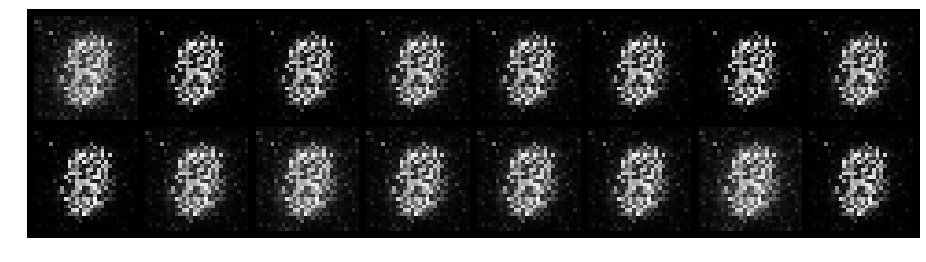

Epoch: [0/200], Batch Num: [0/600]
Discriminator Loss: 0.6341, Generator Loss: 2.9451
D(x): 0.7246, D(G(z)): 0.1890


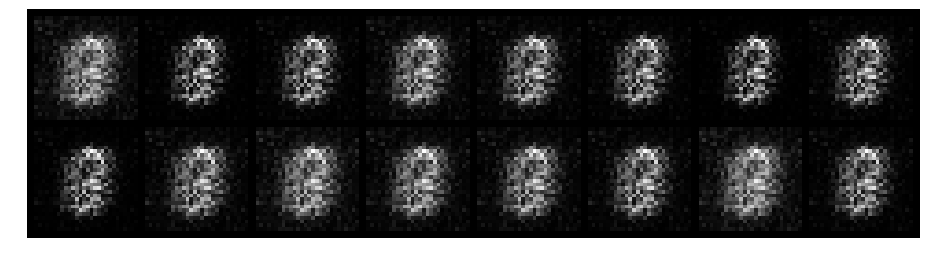

Epoch: [0/200], Batch Num: [100/600]
Discriminator Loss: 0.5854, Generator Loss: 2.0427
D(x): 0.7788, D(G(z)): 0.2162


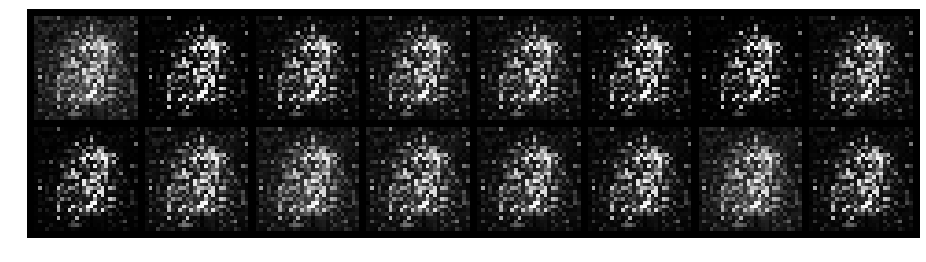

Epoch: [0/200], Batch Num: [200/600]
Discriminator Loss: 0.6090, Generator Loss: 2.8867
D(x): 0.7661, D(G(z)): 0.2300


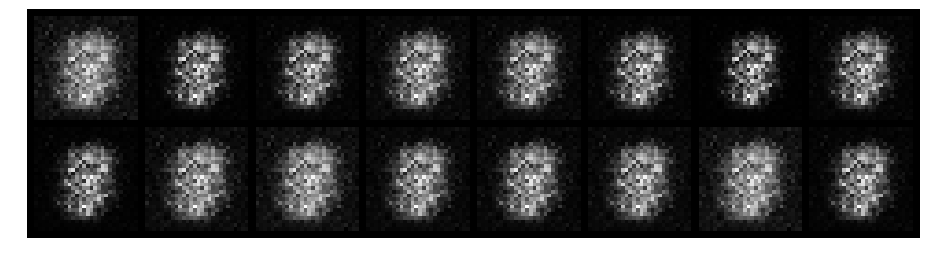

Epoch: [0/200], Batch Num: [300/600]
Discriminator Loss: 1.6906, Generator Loss: 0.6240
D(x): 0.5632, D(G(z)): 0.6081


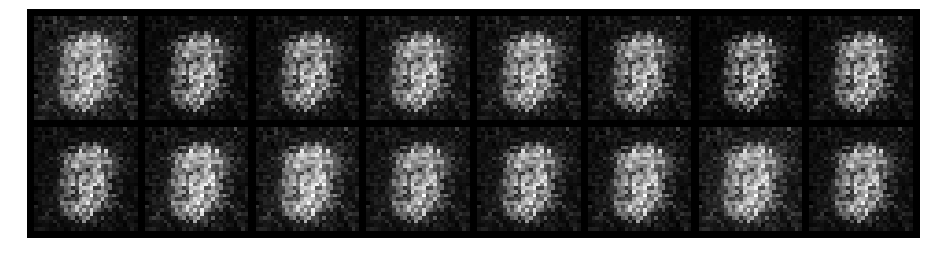

Epoch: [0/200], Batch Num: [400/600]
Discriminator Loss: 1.4572, Generator Loss: 0.6069
D(x): 0.5574, D(G(z)): 0.5519


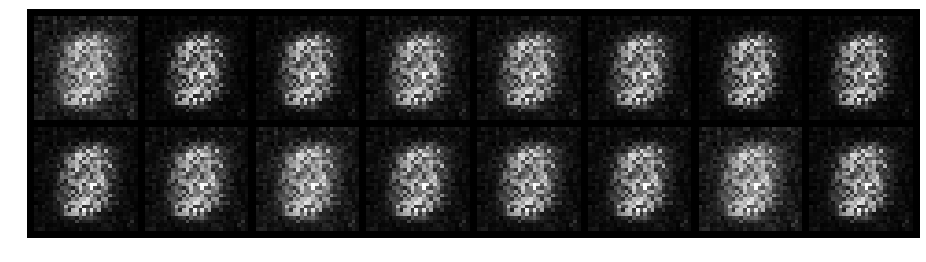

Epoch: [0/200], Batch Num: [500/600]
Discriminator Loss: 1.7869, Generator Loss: 0.7293
D(x): 0.5346, D(G(z)): 0.5982


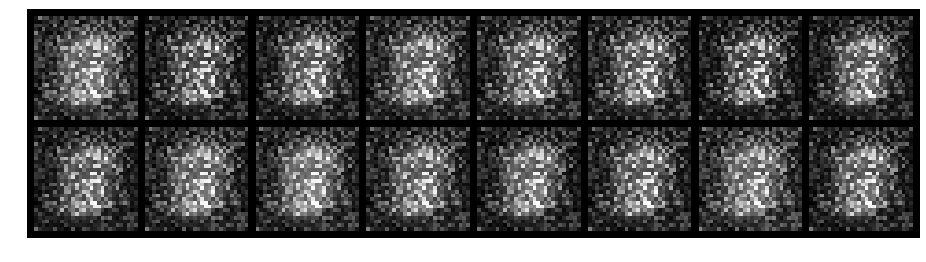

Epoch: [1/200], Batch Num: [0/600]
Discriminator Loss: 0.6346, Generator Loss: 3.5687
D(x): 0.7984, D(G(z)): 0.2678


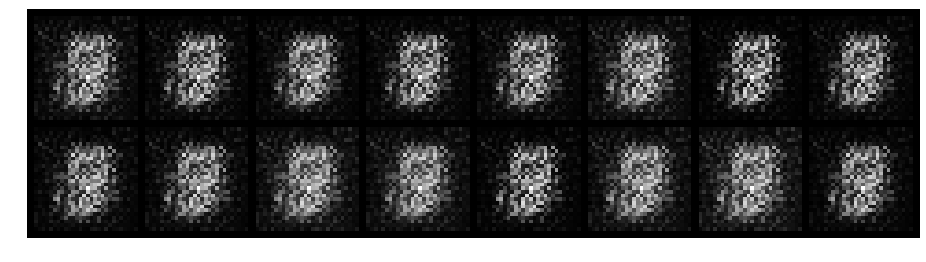

Epoch: [1/200], Batch Num: [100/600]
Discriminator Loss: 1.4679, Generator Loss: 1.7138
D(x): 0.6542, D(G(z)): 0.4856


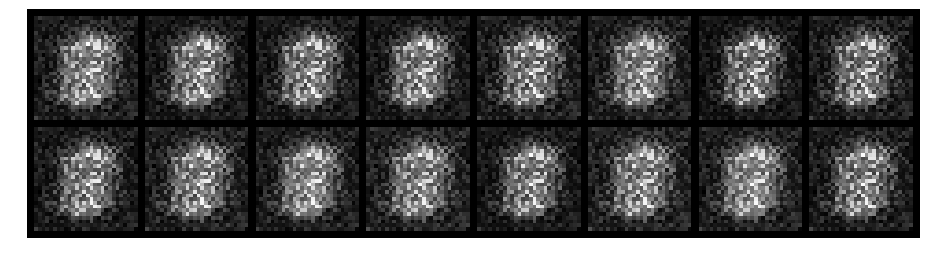

Epoch: [1/200], Batch Num: [200/600]
Discriminator Loss: 0.7642, Generator Loss: 1.5074
D(x): 0.7555, D(G(z)): 0.3402


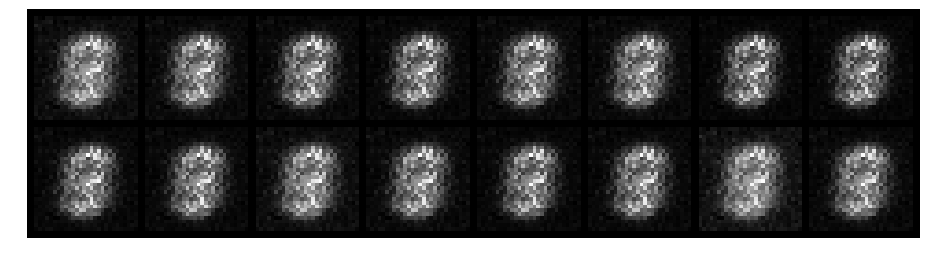

Epoch: [1/200], Batch Num: [300/600]
Discriminator Loss: 0.7342, Generator Loss: 2.0885
D(x): 0.7212, D(G(z)): 0.2351


KeyboardInterrupt: 

In [31]:
for epoch in range(num_epochs):
    
    # Vamos iterando y generando batches de datos reales
    for n_batch, (real_batch,_) in enumerate(data_loader):
        
        num_samples = real_batch.size(0) # Para conocer el numero de muestras
        
        # 1. Entrenamos el discriminador
        #  -> Transformamos las imagenes reales a vectores 
        real_data = Variable(images_to_vectors(real_batch))
        # Generamos datos falsos (con el generador) y hacemos detach
        # Para que no se calculen gradientes ni nada raro en el generador
        fake_data = generator(noise(num_samples)).detach()
        # ---> Entrenamos el discriminador
        d_error, d_pred_real, d_pred_fake = train_discriminator(discriminator_optimizer, real_data, fake_data)
        
        # 2. Entrenamos el generador
        # Generamos datos falsos (con el generador)
        fake_data = generator(noise(num_samples))
        # ---> Entrenamos el generador
        g_error = train_generator(generator_optimizer, fake_data)
        
        
        # Tareas de LOGGING!
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        
        # Mostramos el progreso cada pocos batches
        if n_batch % 100 == 0:
            test_images = vectors_to_images(generator(test_noise)).cpu()
            test_images = test_images.data
            
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches)
            # Display status log
            logger.display_status(epoch, num_epochs, n_batch, num_batches, 
                                  d_error, g_error, d_pred_real, d_pred_fake)